In [2]:
import os
import cv2
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Conv2DTranspose
from keras.layers import BatchNormalization
from keras.layers import concatenate 
from keras.optimizers import Adam
from google.colab.patches import cv2_imshow

In [ ]:
#from google.colab import drive
#drive.mount('/gdrive')
#drive.mount('/content/drive')

In [4]:
! unzip "/content/segImages-20210309T100249Z-001.zip"

Archive:  /content/mriimages-20210309T100248Z-001.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /content/mriimages-20210309T100248Z-001.zip or
        /content/mriimages-20210309T100248Z-001.zip.zip, and cannot find /content/mriimages-20210309T100248Z-001.zip.ZIP, period.
Archive:  /content/segImages-20210309T100249Z-001.zip
  inflating: segImages/segimg1880.jpg  
  inflating: segImages/segimg1900.jpg  
  inflating: segImages/segimg1885.jpg  
  inflating: segImages/segimg1881.jpg  
  inflating: segImages/segimg1888.jpg  
  inflating: segImages/segimg1882.jpg  
  inflating: segImages/segimg1889.jpg  
  inflating: segImages/segimg1887.jpg  
  inflating: segImages/segimg1883.jpg  
  inflating: segImages/segimg1884.jpg  
  inflating:

In [12]:
! unzip "/content/mriimages-20210309T100248Z-001.zip"

Archive:  /content/mriimages-20210309T100248Z-001.zip
  inflating: mriimages/img1898.jpg   
  inflating: mriimages/img1893.jpg   
  inflating: mriimages/img1891.jpg   
  inflating: mriimages/img1896.jpg   
  inflating: mriimages/img1899.jpg   
  inflating: mriimages/img1895.jpg   
  inflating: mriimages/img1878.jpg   
  inflating: mriimages/img1884.jpg   
  inflating: mriimages/img1897.jpg   
  inflating: mriimages/img1879.jpg   
  inflating: mriimages/img1869.jpg   
  inflating: mriimages/img1881.jpg   
  inflating: mriimages/img1874.jpg   
  inflating: mriimages/img1887.jpg   
  inflating: mriimages/img1882.jpg   
  inflating: mriimages/img1889.jpg   
  inflating: mriimages/img1880.jpg   
  inflating: mriimages/img1883.jpg   
  inflating: mriimages/img1885.jpg   
  inflating: mriimages/img1870.jpg   
  inflating: mriimages/img1890.jpg   
  inflating: mriimages/img1873.jpg   
  inflating: mriimages/img1892.jpg   
  inflating: mriimages/img1900.jpg   
  inflating: mriimages/img1861.jpg

In [13]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),
                padding = 'same', activation = 'relu')(input_tensor)

    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),
                 padding = 'same',activation = 'relu')(x)

    x = x = BatchNormalization()(x) 
    
    return x


def get_unet(input_img, n_filters = 64, dropout = 0.1):
    print("input image shape",input_img.shape)
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3)
    p1 = MaxPooling2D((2, 2))(c1)
    #p1 = Dropout(dropout)(p1)
    print("p1",p1.shape)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3)
    p2 = MaxPooling2D((2, 2))(c2)
    #p2 = Dropout(dropout)(p2)
    print("p2",p2.shape)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3)
    p3 = MaxPooling2D((2, 2))(c3)
    #p3 = Dropout(dropout)(p3)
    print("p3",p3.shape)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3)
    p4 = MaxPooling2D((2, 2))(c4)
    #p4 = Dropout(dropout)(p4)
    print("p4",p4.shape)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    #u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3)
    print("c6",c6.shape)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    #u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3)
    print("u7",u7.shape)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    #u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3)
    print("c8",c8.shape)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    #u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3)
    print("c9",c9.shape)
    
    img_output = Conv2D(4, (1, 1), activation='softmax')(c9)
    #tf.compat.v1.disable_eager_execution()
    #print("img_output",img_output.shape)
    model = tf.keras.Model(inputs = [input_img], outputs = [img_output])
    #model.summary()
    return model

In [ ]:
#tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
#not needed
'''#img_input=tf.random.uniform(shape=[1,128,128,3], minval=1, maxval=5, dtype=tf.float32, seed=10)
img_input=Input(shape=(128, 128, 1)) #Input is an inbuilt function in tf.keras.layers
#img_input.dtype
#img_input=tf.Variable(img_input)
model = get_unet(img_input, n_filters=16, dropout=0.05)
model.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"])'''

'#img_input=tf.random.uniform(shape=[1,128,128,3], minval=1, maxval=5, dtype=tf.float32, seed=10)\nimg_input=Input(shape=(128, 128, 1)) #Input is an inbuilt function in tf.keras.layers\n#img_input.dtype\n#img_input=tf.Variable(img_input)\nmodel = get_unet(img_input, n_filters=16, dropout=0.05)\nmodel.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"])'

In [18]:
import os
import numpy as np
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split

#input_image = np.array([])
#input_mask = np.array([])

def data_augment(input_image,input_mask):
    if tf.random.uniform((1,)) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
        #input_mask = np.reshape(input_mask, (256,256))
    return input_image, input_mask
            
def data_processing():
    image_dir = '/content/mriimages'
    mask_dir = '/content/segImages'
        
    images = os.listdir(image_dir)
    masks = ["seg" + a for a in images]

    mri_imgs = [os.path.join(image_dir, a) for a in images]
    seg_imgs = [os.path.join(mask_dir, a) for a in masks]
    
    #mriimgs = [f for f in glob.glob(path + "*/*.jpg", recursive=True)]
    #segimgs = [f for f in glob.glob(path1 + "*/*.jpg", recursive=True)]

    #print(mriimgs[0:5],'\n', segimgs[0:5])

    images = []
    mask = []

    for i in range(0,len(seg_imgs)):
    
        #images.append(np.array(Image.open(mriimgs[i]), dtype = np.float32))
        image1 = cv2.imread(mri_imgs[i],cv2.IMREAD_GRAYSCALE)
        mask1 = cv2.imread(seg_imgs[i],cv2.IMREAD_GRAYSCALE)
        a=b=c=d=mask1
        
        #mask1=mask1.astype(int)
        a = cv2.inRange(a,0,70)
        mask1[a>200] = 0 #cv2.inrange returns white in those areas of the specified pixels
        
        b=cv2.inRange(b,127,190)
        mask1[b>200] = 1
        
        c=cv2.inRange(c,71,126)
        mask1[c>200] = 2
        
        d=cv2.inRange(d,190,255)
        mask1[d>200] = 3
        
        image1  = image1.reshape(256,256,1)
        mask1 = mask1.reshape(256,256,1)
        #cv2_imshow(mask1*70)
        
        image1, mask1 = data_augment(image1, mask1)
        #cv2_imshow(mask1*60)
        images.append(image1)
        mask.append(mask1)
    return images, mask

In [19]:
train_input, train_target = data_processing()

In [20]:
train_valid_x, test_x = train_test_split(train_input, test_size=0.01, random_state = 50) #180 for test
train_valid_y, test_y = train_test_split(train_target, test_size=0.01, random_state = 50)

train_x, valid_x = train_test_split(train_valid_x, test_size=0.2, random_state = 50)
train_y, valid_y = train_test_split(train_valid_y, test_size=0.2, random_state = 50)

In [21]:
tf.test.is_built_with_cuda()

True

In [22]:
def tf_dataset(x, y, batch_size=32):
  dataset = tf.data.Dataset.from_tensor_slices((x, y))
  dataset = dataset.batch(batch_size=32)
  return dataset  

In [23]:
t = tf_dataset(train_x, train_y, batch_size=32)
v = tf_dataset(valid_x, valid_y, batch_size=32)

(256, 256, 1)


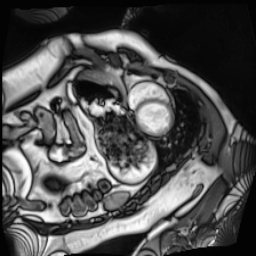

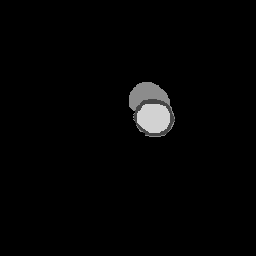

In [ ]:
for im, tg in v:
  print(im[0].shape)
  cv2_imshow(im[0].numpy())
  cv2_imshow(tg[0].numpy()*70)
  break

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

'''Hyperparameters'''
lr = 1e-4
batch_size = 64
epochs = 10

img_input=tf.keras.layers.Input(shape=(256, 256, 1))#channel is 1 because the input image is in grayscale
model = get_unet(img_input, n_filters=64)
model.compile(optimizer=Adam(lr), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,), 
              metrics=["accuracy"])

#train_dataset = tf.data.Dataset(train_x, train_y, batch=batch_size)
#valid_dataset = tf.dataDataset(valid_x, valid_y, batch=batch_size)

train_steps = len(train_x)//batch_size
valid_steps = len(valid_x)//batch_size

'''callbacks = [
    ModelCheckpoint("model.h5",verbose=1,save_best_model=True),
    ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.1, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor="val_loss", patience=2, verbose=1)
]'''

input image shape (None, 256, 256, 1)
p1 (None, 128, 128, 64)
p2 (None, 64, 64, 128)
p3 (None, 32, 32, 256)
p4 (None, 16, 16, 512)
c6 (None, 32, 32, 512)
u7 (None, 64, 64, 512)
c8 (None, 128, 128, 128)
c9 (None, 256, 256, 64)


'callbacks = [\n    ModelCheckpoint("model.h5",verbose=1,save_best_model=True),\n    ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.1, verbose=1, min_lr=1e-6),\n    EarlyStopping(monitor="val_loss", patience=2, verbose=1)\n]'

In [ ]:
model.fit(t,
          epochs=epochs, 
          validation_data=v,
         )

Epoch 1/10
45/45 [==============================] - 41s 880ms/step - loss: 1.5148 - accuracy: 0.3864 - val_loss: 2.3313 - val_accuracy: 0.3366
Epoch 2/10
45/45 [==============================] - 39s 868ms/step - loss: 0.9352 - accuracy: 0.9047 - val_loss: 0.7601 - val_accuracy: 0.8214
Epoch 3/10
45/45 [==============================] - 39s 870ms/step - loss: 0.6953 - accuracy: 0.9593 - val_loss: 0.2154 - val_accuracy: 0.9599
Epoch 4/10
45/45 [==============================] - 39s 871ms/step - loss: 0.5473 - accuracy: 0.9769 - val_loss: 0.2346 - val_accuracy: 0.9603
Epoch 5/10
45/45 [==============================] - 39s 870ms/step - loss: 0.4703 - accuracy: 0.9817 - val_loss: 0.2639 - val_accuracy: 0.9603
Epoch 6/10
45/45 [==============================] - 39s 871ms/step - loss: 0.3846 - accuracy: 0.9864 - val_loss: 0.1751 - val_accuracy: 0.9648
Epoch 7/10
45/45 [==============================] - 39s 871ms/step - loss: 0.3347 - accuracy: 0.9891 - val_loss: 0.1065 - val_accuracy: 0.9772

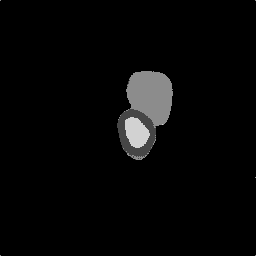

In [ ]:
for im, tg in v:
  prediction=model.predict(im)
  prediction=tf.argmax(prediction,axis=3)
  cv2_imshow(prediction[25].numpy()*70)
  break

In [ ]:
print(train_x[0].shape)
a = np.reshape(train_x[0], (1,256,256,1))
b = model.predict(a)
b.shape

(256, 256, 1)


(1, 256, 256, 4)

In [ ]:
"""OVER...OVER...OVER"""